### Data Exploration and Preprocessing

#### Initialise Spark Session and Load Data from HDFS into Spark DataFrames

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("MovieLensAnalysis").config("spark.executor.heartbeatInterval", "100s").config("spark.network.timeout", "600s").getOrCreate()

movies_df = spark.read.csv("hdfs://namenode:9000/movies.csv", header=True, inferSchema=True)
ratings_df = spark.read.csv("hdfs://namenode:9000/ratings.csv", header=True, inferSchema=True)
tags_df = spark.read.csv("hdfs://namenode:9000/tags.csv", header=True, inferSchema=True)
links_df = spark.read.csv("hdfs://namenode:9000/links.csv", header=True, inferSchema=True)

#### Explore Data Schema and Sample Records

In [2]:
movies_df.printSchema()
movies_df.show(5)

ratings_df.printSchema()
ratings_df.show(5)

tags_df.printSchema()
tags_df.show(5)

links_df.printSchema()
links_df.show(5)

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47| 

#### Handle Missing Values and Duplicates

In [3]:
movies_df = movies_df.na.drop()
ratings_df = ratings_df.na.drop()
tags_df = tags_df.na.drop()
links_df = links_df.na.drop()

movies_df = movies_df.dropDuplicates()
ratings_df = ratings_df.dropDuplicates()
tags_df = tags_df.dropDuplicates()
links_df = links_df.dropDuplicates()

#### Split Genres into array

In [4]:
from pyspark.sql.functions import split

movies_df = movies_df.withColumn("genres_array", split(movies_df["genres"], "\\|"))

### CRUD Operations
#### Create

In [5]:
from pyspark.sql import Row
from pyspark.sql.functions import split

movies_df_copy = movies_df


new_movie = Row(movieId=999999, title="New Movie (2024)", genres="Sci-Fi|Drama")


new_movie_df = spark.createDataFrame([new_movie])
new_movie_df = new_movie_df.withColumn("genres_array", split(new_movie_df["genres"], "\\|"))
movies_df_copy = movies_df_copy.select("movieId", "title", "genres").withColumn("genres_array", split(movies_df_copy["genres"], "\\|"))
movies_df_copy = movies_df_copy.union(new_movie_df.select("movieId", "title", "genres", "genres_array"))
movies_df_copy.filter(movies_df_copy.movieId == 999999).show()

+-------+----------------+------------+---------------+
|movieId|           title|      genres|   genres_array|
+-------+----------------+------------+---------------+
| 999999|New Movie (2024)|Sci-Fi|Drama|[Sci-Fi, Drama]|
+-------+----------------+------------+---------------+



#### Read

In [6]:
from pyspark.sql.functions import regexp_extract, col

# filter movies by sci-fi genre
sci_fi_movies = movies_df_copy.filter(
    (movies_df.genres.contains("Sci-Fi"))
)

# select and display the top 5 movies
sci_fi_movies.select("title", "genres").show(5, truncate=False)

+-------------------------------------------------------------------------+-----------------------------------------+
|title                                                                    |genres                                   |
+-------------------------------------------------------------------------+-----------------------------------------+
|Sword Art Online The Movie: Ordinal Scale (2017)                         |Action|Adventure|Animation|Fantasy|Sci-Fi|
|Incredible Shrinking Woman, The (1981)                                   |Comedy|Sci-Fi                            |
|Kid's Story (2003)                                                       |Animation|Sci-Fi                         |
|Abominable Snowman, The (Abominable Snowman of the Himalayas, The) (1957)|Horror|Sci-Fi                            |
|Highlander II: The Quickening (1991)                                     |Action|Sci-Fi                            |
+-------------------------------------------------------

#### Update

In [7]:
from pyspark.sql.functions import when

# update the genres for the movie with movieId = 999999 (one I created ealier)
movies_df_copy = movies_df_copy.withColumn(
    "genres",
    when(movies_df_copy.movieId == 999999, "Thriller|Action").otherwise(movies_df_copy.genres)
)

# Verify the update
movies_df_copy.filter(movies_df_copy.movieId == 999999).select("movieId", "title", "genres").show()

+-------+----------------+---------------+
|movieId|           title|         genres|
+-------+----------------+---------------+
| 999999|New Movie (2024)|Thriller|Action|
+-------+----------------+---------------+



#### Delete

In [8]:
from pyspark.sql.functions import regexp_extract

movies_df_copy = movies_df_copy.withColumn("year", regexp_extract(movies_df_copy["title"], r"\((\d{4})\)", 1))
movies_df_copy = movies_df_copy.filter(movies_df_copy.year != "2020")

movies_df_copy.write.mode("overwrite").parquet("hdfs://namenode:9000/movies_df_copy")

### Complex Big Data Queries Using Spark SQL

In [9]:
movies_df.createOrReplaceTempView("movies")
ratings_df.createOrReplaceTempView("ratings")
tags_df.createOrReplaceTempView("tags")
links_df.createOrReplaceTempView("links")

#### Query 1: Top Tags Associated with High-Rated Movies

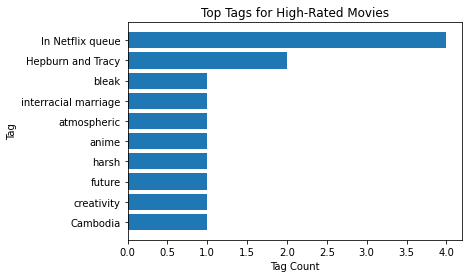

In [10]:
import matplotlib.pyplot as plt
top_tags = spark.sql("""
SELECT
    t.tag,
    COUNT(*) AS tag_count
FROM tags t
JOIN (
    SELECT
        movieId,
        AVG(rating) AS avg_rating
    FROM ratings
    GROUP BY movieId
    HAVING avg_rating > 4.5
) high_rated_movies ON t.movieId = high_rated_movies.movieId
GROUP BY t.tag
ORDER BY tag_count DESC
LIMIT 10
""")

top_tags_pd = top_tags.toPandas()
plt.barh(top_tags_pd['tag'], top_tags_pd['tag_count'])
plt.xlabel('Tag Count')
plt.ylabel('Tag')
plt.title('Top Tags for High-Rated Movies')
plt.gca().invert_yaxis()
plt.show()

#### Query 2: Top Genres by Average Rating

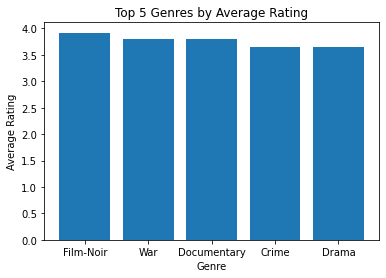

In [11]:
top_genres = spark.sql("""
SELECT
    genre,
    AVG(avg_rating) AS avg_genre_rating
FROM (
    SELECT
        genre,
        AVG(r.rating) AS avg_rating
    FROM movies m
    JOIN ratings r ON m.movieId = r.movieId
    LATERAL VIEW explode(m.genres_array) AS genre
    GROUP BY genre
) tmp
GROUP BY genre
ORDER BY avg_genre_rating DESC
LIMIT 5
""")

top_genres_pd = top_genres.toPandas()
plt.bar(top_genres_pd['genre'], top_genres_pd['avg_genre_rating'])
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.title('Top 5 Genres by Average Rating')
plt.show()

####  Query 3: Correlation Between Movie Popularity and Average Rating

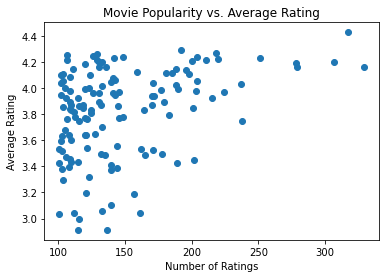

In [12]:
popularity_vs_rating = spark.sql("""
SELECT
    m.movieId,
    m.title,
    COUNT(r.rating) AS num_ratings,
    AVG(r.rating) AS avg_rating
FROM movies m
JOIN ratings r ON m.movieId = r.movieId
GROUP BY m.movieId, m.title
HAVING COUNT(r.rating) > 100
ORDER BY num_ratings DESC
""")

popularity_vs_rating_pd = popularity_vs_rating.toPandas()
plt.scatter(popularity_vs_rating_pd['num_ratings'], popularity_vs_rating_pd['avg_rating'])
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.title('Movie Popularity vs. Average Rating')
plt.show()

#### Query 4: Most Active Users and the Movies They Rated the Most

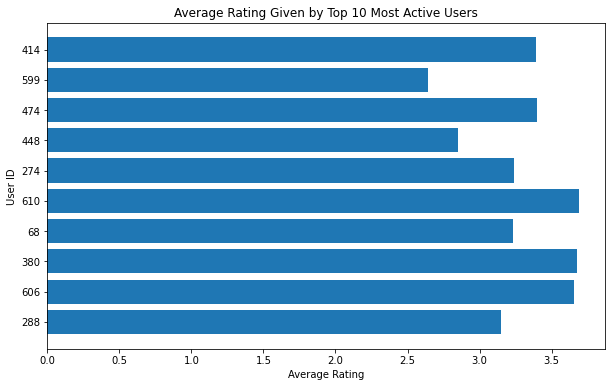

In [13]:
most_active_users_avg = spark.sql("""
SELECT
    r.userId,
    COUNT(r.movieId) AS movie_count,
    AVG(r.rating) AS avg_rating
FROM ratings r
JOIN movies m ON r.movieId = m.movieId
GROUP BY r.userId
ORDER BY movie_count DESC
LIMIT 10
""")

import matplotlib.pyplot as plt

most_active_users_avg_pd = most_active_users_avg.toPandas()
plt.figure(figsize=(10,6))
plt.barh(most_active_users_avg_pd['userId'].astype(str), 
         most_active_users_avg_pd['avg_rating'])
plt.xlabel('Average Rating')
plt.ylabel('User ID')
plt.title('Average Rating Given by Top 10 Most Active Users')
plt.gca().invert_yaxis()
plt.show()